#  Imports and Data Loading


In [1]:
# Packages for numerics + dataframes
import pandas as pd
import numpy as np

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for Logistic Regression & Confusion Matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression


In [2]:
df = pd.read_csv('waze_dataset.csv')

In [3]:
#Dropping the ID column
df = df.drop('ID', axis=1)

# Feature Creation / Variable Modification


#### **`km_per_driving_day`**

(Known from earlier EDA files) Churn rate correlates with distance driven per driving day in the last month.

In [4]:
# 1. Create `km_per_driving_day` column
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

_Some values are infinite because there are values of **zero** in the `driving_days` column._

In [5]:
# 1. Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`professional_driver`**

A new binary feature that is a 1 for users who had 60 or more drives <u>**and**</u> drove on 15+ days in the last month.


In [6]:
# Create `professional_driver` column
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

In [7]:
# 1. Check count of professionals and non-professionals
print(df['professional_driver'].value_counts())

# 2. Check in-class churn rate
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

0    12405
1     2594
Name: professional_driver, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: label, dtype: float64

The churn rate for professional drivers is 7.6%, while the churn rate for non-professionals is 19.9%. **_This seems like it could add predictive signal to the model._**

## Remove N/A Rows Within Column 'Label'

(Known from previous EDA file) There is no evidence of a non-random cause of the 700 missing values in the `label` column, and because these observations comprise less than 5% of the data, I will drop these rows.

In [8]:
# Drop rows with missing data in `label` column
df = df.dropna(subset=['label'])

## Impute outliers

(Known from previous EDA file) 7 of the variables had clear signs of containing outliers:

* `sessions`
* `drives`
* `total_sessions`
* `total_navigations_fav1`
* `total_navigations_fav2`
* `driven_km_drives`
* `duration_minutes_drives`



In [9]:
# Impute outliers at 95th percentile threshold
for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1',
               'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']:
    threshold = df[column].quantile(0.95)
    df.loc[df[column] > threshold, column] = threshold

In [10]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,76.539688,63.964683,183.717304,1751.822505,114.562767,27.187216,3944.558631,1792.911210,15.544653,12.182530,581.942399,0.173998
std,67.243178,55.127927,118.720520,1008.663834,124.378550,36.715302,2218.358258,1224.329759,9.016088,7.833835,1038.254509,0.379121
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,136.168003,0.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,273.301012,0.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,558.018761,0.000000
max,243.000000,200.000000,455.439492,3500.000000,422.000000,124.000000,8898.716275,4668.180092,31.000000,30.000000,15420.234110,1.000000


## Encode categorical variables

I will convert the data type of the `label` column to be binary. This change is needed to train the logistic regression model.

`0` for all `retained` users.

`1` for all `churned` users.


In [11]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


# Logistic Regression Model Assumptions Check

The following are the assumptions for logistic regression:

* Independent observations

* No extreme outliers

* Little to no multicollinearity among X predictors

* Linear relationship between X and the **logit** of y

For the first assumption, the observations are independent for this project.

The second assumption has already been addressed.

The last assumption will be verified after modeling.

### Collinearity

In [12]:
# Generate a correlation matrix
df.corr(method='pearson')

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label2
sessions,1.000000,0.996942,0.597189,0.007101,0.001858,0.008536,0.002996,-0.004545,0.025113,0.020294,-0.011569,0.443654,0.034911
drives,0.996942,1.000000,0.595285,0.006940,0.001058,0.009505,0.003445,-0.003889,0.024357,0.019608,-0.010989,0.444425,0.035865
total_sessions,0.597189,0.595285,1.000000,0.006596,0.000187,0.010371,0.001016,-0.000338,0.015755,0.012953,-0.016167,0.254433,0.024568
n_days_after_onboarding,0.007101,0.006940,0.006596,1.000000,-0.002450,-0.004968,-0.004652,-0.010167,-0.009418,-0.007321,0.011764,0.003770,-0.129263
total_navigations_fav1,0.001858,0.001058,0.000187,-0.002450,1.000000,0.002866,-0.007368,0.005646,0.010902,0.010419,-0.000197,-0.000224,0.052322
total_navigations_fav2,0.008536,0.009505,0.010371,-0.004968,0.002866,1.000000,0.003559,-0.003009,-0.004425,0.002000,0.006751,0.007126,0.015032
driven_km_drives,0.002996,0.003445,0.001016,-0.004652,-0.007368,0.003559,1.000000,0.690515,-0.007441,-0.009549,0.344811,-0.000904,0.019767
duration_minutes_drives,-0.004545,-0.003889,-0.000338,-0.010167,0.005646,-0.003009,0.690515,1.000000,-0.007895,-0.009425,0.239627,-0.012128,0.040407
activity_days,0.025113,0.024357,0.015755,-0.009418,0.010902,-0.004425,-0.007441,-0.007895,1.000000,0.947687,-0.397433,0.453825,-0.303851
driving_days,0.020294,0.019608,0.012953,-0.007321,0.010419,0.002000,-0.009549,-0.009425,0.947687,1.000000,-0.407917,0.469776,-0.294259


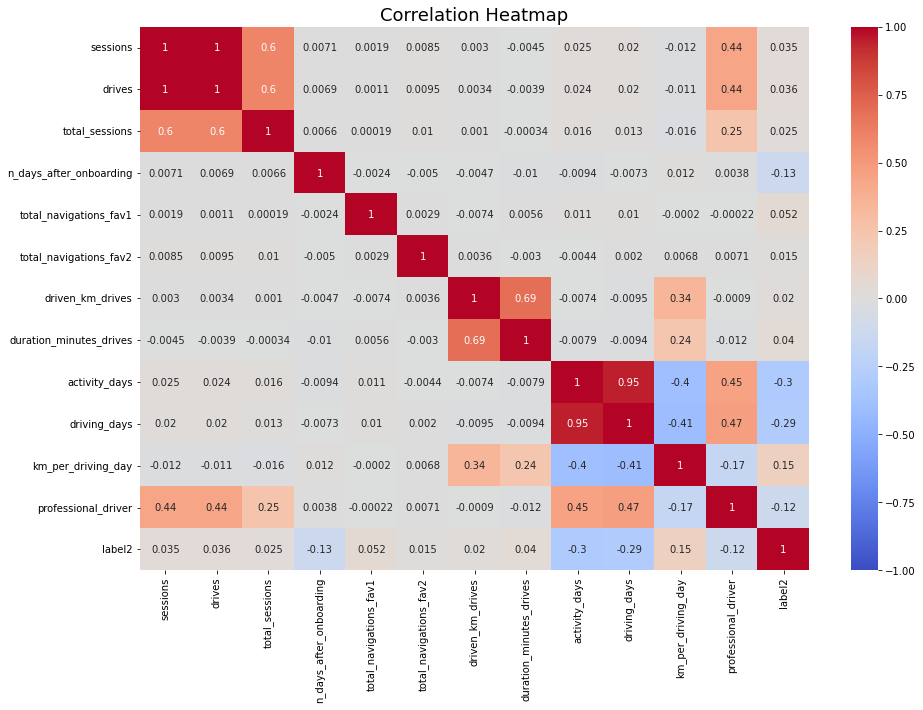

In [13]:
# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap',
          fontsize=18)
plt.show();

### Variables with high multicollinearity:

> * *`sessions` and `drives`: 1.0*
<br>
> * *`driving_days` and `activity_days`: 0.95*

## Assigning Numerical Values to Categorical Variable 'Device'

In [14]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


# Model building

### Assign predictor variables and target

I will be dropping the following variables, and assign the rest to my predictor variables `X`:

* `label` (this is the target)
* `label2` (this is the target)
* `device` (this is the non-binary-encoded categorical variable)
* `sessions` (this had high multicollinearity with `drives`)
* `driving_days` (this had high multicollinearity with `activity_days`)

#### **The reason I decided to keep `drives` and `activity_days` instead is because these features had slightly stronger correlations with the target variable `label2`.**

In [15]:
# Isolate predictor variables
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])

In [16]:
# Isolate target variable
y = df['label2']

### Split the data

In [17]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [18]:
X_train.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,device2
152,108,186.192746,3116,243,124,8898.716275,4668.180092,24,612.305861,1,1
11899,2,3.487590,794,114,18,3286.545691,1780.902733,5,3286.545691,0,1
10937,139,347.106403,331,4,7,7400.838975,2349.305267,15,616.736581,0,0
669,108,455.439492,2320,11,4,6566.424830,4558.459870,18,410.401552,1,1
8406,10,89.475821,2478,135,0,1271.248661,938.711572,27,74.779333,0,1


### Train and Fit the Model

In [19]:
model = LogisticRegression(penalty='none', max_iter=400)

# Fit the model
model.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Check Final Logistic Regression Assumption

The final assumption needed to be checked for the Linear Regression Model:

* Linear relationship between X and the **logit** of y

**Note:** Assume the linear relationship is met for all other X variables

In [20]:
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.93963483, 0.06036517],
       [0.61967304, 0.38032696],
       [0.76463181, 0.23536819],
       ...,
       [0.91909641, 0.08090359],
       [0.85092112, 0.14907888],
       [0.93516293, 0.06483707]])

In [21]:
# 1. Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train.copy()

# 2. Create a new `logit` column in the `logit_data` df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

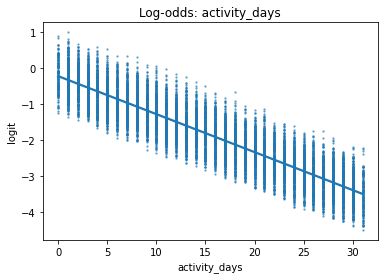

In [22]:
# Plot regplot of `activity_days` log-odds 
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days');

# Results and Evaluation

The Logistic Regression Model Assumptions have been met, so the models results can be appropriately interpreted.


In [23]:
# Generate predictions on X_test
y_preds = model.predict(X_test)

In [24]:
# Score the model (accuracy) on the test data
model.score(X_test, y_test)

0.8237762237762237

In [25]:
#Generate Confusion Matrix metrics
cm = confusion_matrix(y_test, y_preds)

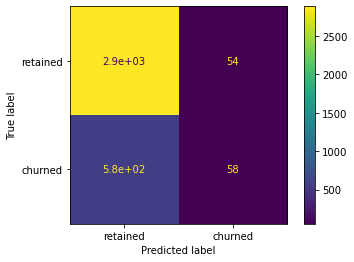

In [26]:
#Display the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned'],
                              )
disp.plot();

In [27]:
# Precision Score
precision = cm[1,1] / (cm[0, 1] + cm[1, 1])
precision

0.5178571428571429

In [28]:
# Recall Score
recall = cm[1,1] / (cm[1, 0] + cm[1, 1])
recall

0.0914826498422713

In [29]:
# Classification report
target_labels = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.52      0.09      0.16       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



# Conclusion / Findings


> _`activity_days` was by far the most important feature in the model. It had a negative correlation with user churn. This was not surprising, as this variable was very strongly correlated with `driving_days`, which was known from EDA to have a negative correlation with churn._


> _In previous EDA file, user churn rate increased as the values in `km_per_driving_day` increased. The correlation heatmap here in this notebook revealed this variable to have the strongest positive correlation with churn of any of the predictor variables by a relatively large margin. In the model, it was the second-least-important variable._


> _In a multiple logistic regression model, features can interact with each other and these interactions can result in seemingly counterintuitive relationships. This is both a strength and a weakness of predictive models, as capturing these interactions typically makes a model more predictive while at the same time making the model more difficult to explain._


> _It depends if I would recommend this model to the Waze team. What would the model be used for? If it's used to drive consequential business decisions, then no. The model is not a strong enough predictor, as made clear by its poor recall score. However, if the model is only being used to guide further exploratory efforts, then it can have value._


> _New features could be engineered to try to generate better predictive signal. In the case of this model, one of the engineered features (`professional_driver`) was the third-most-predictive predictor. It could also be helpful to scale the predictor variables, and/or to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features._